In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    # "font.sans-serif": "Helvetica",
})

%config InlineBackend.figure_format='svg'

In [2]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
data = {'Method':['U-Net', 'Att-UNet', 'U-Net++','MultiResUNet','Residual U-Net', 'TransUNet', 'UCTransNet', 'MISSFormer'],
        '# Params': [1.95, 34.88, 9.16, 7.82, 13.04, 105.28, 66.43, 42.46],
        'GFLOPS': [8.2, 51.02, 26.72, 15.74, 62.06, 80.68, 32.99, 7.25],
        'DiceSynapse': [0.7685, 0.7777, 0.7665, 0.7592, 0, 0.7748, 0.7823, 0.8196],
        'DiceSegPC': [0.8808, 0.9158, 0.9102, 0.8649, 0.8479, 0.8233, 0.9174, 0.8082],
        'DiceISIC': [0.8674, 0.8820, 0.8822, 0.7306, 0.8529, 0.8499, 0.8898, 0.8657]}
df = pd.DataFrame(data)
df.head
df.dtypes

Method          object
# Params       float64
GFLOPS         float64
DiceSynapse    float64
DiceSegPC      float64
DiceISIC       float64
dtype: object

In [4]:
max_param = df['# Params'].max()
max_flops = df['GFLOPS'].max()

df['Memory'] = df['# Params'].map(lambda x: round(1-(x/max_param), 2))
df['Complexity'] = df['GFLOPS'].map(lambda x: round(1-(x/max_flops), 2))

In [5]:
list(df['DiceSynapse'])
df['Memory']
df.head(8)

,Method,# Params,GFLOPS,DiceSynapse,DiceSegPC,DiceISIC,Memory,Complexity
0,U-Net,1.95,8.20,0.7685,0.8808,0.8674,0.98,0.90
1,Att-UNet,34.88,51.02,0.7777,0.9158,0.8820,0.67,0.37
2,U-Net++,9.16,26.72,0.7665,0.9102,0.8822,0.91,0.67
3,MultiResUNet,7.82,15.74,0.7592,0.8649,0.7306,0.93,0.80
4,Residual U-Net,13.04,62.06,0.0000,0.8479,0.8529,0.88,0.23
5,TransUNet,105.28,80.68,0.7748,0.8233,0.8499,0.00,0.00
6,UCTransNet,66.43,32.99,0.7823,0.9174,0.8898,0.37,0.59
7,MISSFormer,42.46,7.25,0.8196,0.8082,0.8657,0.60,0.91


In [6]:
list(df.iloc[0][['DiceSynapse', 'DiceSegPC', 'DiceISIC', 'Memory', 'Complexity']])

[0.7685, 0.8808, 0.8674, 0.98, 0.9]

In [7]:
def example_data():
    data = [
        ['Dice$_{Synapse}$', 'Dice$_{SegPC2021}$', 'Memory', 'Complexity',  'Dice$_{ISIC2018}$'],
        ('Comparison of ', [
            list(df.iloc[0][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[1][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[2][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[3][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[4][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[5][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[6][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']]),
            list(df.iloc[7][['DiceSynapse', 'DiceSegPC', 'Memory', 'Complexity', 'DiceISIC']])]),
    ]
    return data

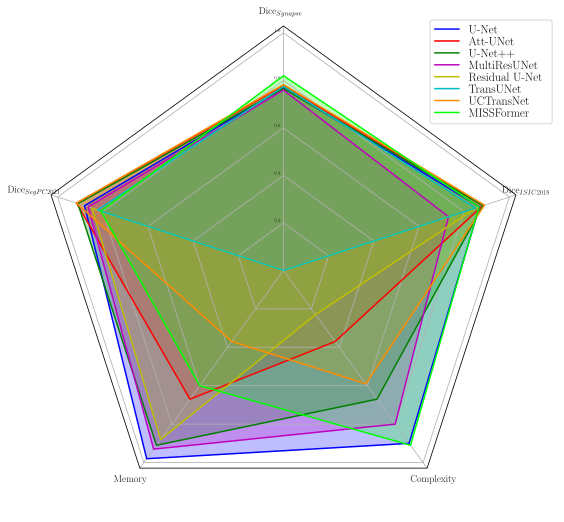

In [8]:
from numpy import angle


N = 5
theta = radar_factory(N, frame='polygon')

data = example_data()
# print(data)
spoke_labels = data.pop(0)
# print(data)

fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
# fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
colors = ['b', 'r', 'g', 'm', 'y', 'c','darkorange', 'lime']

# axs.set_rgrids([0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],fontsize=5)
# axs.set_rgrids([0.2, 0.4, 0.6, 0.8, 1],fontsize=5, angle=0, ha='right', weight='bold')
# axs.set_title('Comprehensive Comparison', weight='bold', position=(0.5, 1.1),
#               horizontalalignment='center', verticalalignment='center', fontsize=20)

case_data = data[0][1]
for d, color in zip(case_data, colors):
    axs.plot(theta, d, color=color)
    axs.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs.set_varlabels(spoke_labels)


labels = tuple(df['Method'])
legend = axs.legend(labels, loc=(0.8, 0.8),
                    labelspacing=0.1, fontsize='large')

axs.set_rgrids([0.2, 0.4, 0.6, 0.8, 1],fontsize=5, angle=0, ha='right', weight='bold')

# fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#             horizontalalignment='center', color='black', weight='bold',
#             size='large')
plt.savefig('ComparisonOfModels.pdf', dpi=300)
plt.show()